# A simple counting experiment

For our simple "HEP"-inspired counting experiment from the lectures, we can write the likelihood as, 

$$
L(\mu,\eta) = \lambda(\mu,\eta)^{n}e^{-\lambda}\cdot e^{-\frac{1}{2}\eta^{2}}
$$

where we've dropped the $n!$ in the likelihood (for reasons that will be clear in the future). $\mu$ is the parameter of interest (relating our measured cross-section to some hypothetical one) and $\eta$ is our nuisance parameter that encodes our uncertainty on the luminosity, 

$$
\lambda(\mu,\eta) = \mu\sigma(pp\rightarrow \mathrm{X})A\epsilon l_{0}\cdot(1+\kappa)^{\eta}+B
$$

We'll assume that we have some specified values given to us. And these have been defined in a file called `counting_model.py`. We can import that to access everything in  the model. 

In [1]:
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

f=open("counting_model.py")
for line in f.readlines(): print(line),

# define the counting experiment

sigma_TH = 0.01

A   = 0.5

eff = 0.9

l   = 100.

k   = 0.3

B   = 0.5

n   = 2 # our measured data


And with these we can specify the Poisson term,

In [2]:
from counting_model import *

# Poisson mean
def lamb(mu,eta):
  return mu*eff*A*l*((1+k)**eta)*sigma_TH + B

Our aim here will be to remove the dependence of the likelihood (and therefore our infrence on $\mu$) on the parameter $\eta$. As explained in lectures, there are two ways  to procede common in HEP, profiling, or marginaisation. 

##  Profiling

Profiling is the method of  removing the dependence on $\eta$ through finding the values of $\eta$ for which $L(\mu,\eta)$ is maximised at each value of $\mu$. Thus $\eta$ becomes a function of $\mu$, i.e 

$$
L(\mu,\eta)\rightarrow L(\mu,\eta(\mu))
$$

Often, since we deal with exponentials, its easier to minimize a negative log-likelihood, than maximise a likelihood. So let's write down the negative log-likelihood function. In fact by convention we also multiply by two (more on that in lectures later). 

$$
q(\mu,\eta) = -2\ln L(\mu,\eta)  = \eta^{2}+2\lambda(\mu,\eta)-2n\ln\lambda(\mu,\eta)
$$

In [3]:
# q = -2lnL
def q(mu,eta):
  la = lamb(mu,eta)
  return eta*eta + 2*la -2*n*numpy.log(la)

To profile the function, we need to find value(s) of $\eta$ for which,

$$
q{\prime} = \frac{\partial q}{\partial \eta} = 0  
$$

We'll use a numerial method known as the "Newton method" to solve this. This method works as follows; 

   * Choose an initial starting point for the parameter, call it $\eta_{0}$.
   * The next point proposed is $\eta_{1}=\eta_{0}-\frac{q\prime(\eta_{0})}{q\prime\prime(\eta_{0})}$. This new point now replaces $\eta_{0}$/ 
   * Continue iterating until $|q\prime|<\delta$, where $\delta$  is some pre-defined tolerance
   
Since we can analytically calculate them, we also write the functions for $q\prime$  and $q\prime\prime$,

In [4]:
# dq/deta
def dq(mu,eta):
  la = lamb(mu,eta)
  dl = (la-B)*numpy.log(1+k)
  return 2.*eta + 2.*dl - 2.*n*dl/la

# d^2q/deta^2
def d2q(mu,eta):
  log_k = numpy.log(1+k)
  la    = lamb(mu,eta)
  dl    = log_k*(la-B)
  d2l   = log_k*log_k*(la-B)
    
  return 2. + 2.*d2l - 2.*n*(1./(la*la))*dl*dl - 2.*n*(1./la)*d2l


Finally, lets put this into a function which returns the profiled value of $\eta$ for a given value of $\mu$. 

In [5]:
def profiled_eta(mu):
  # numerical minimumisation via newton method
  tol = 0.01
  #init_eta =-0.5 if lamb(mu,0)-n > 0 else 0.5
  init_eta = 0.
  eps = 100
  while eps > tol:
    qp = dq(mu,init_eta)
    eps = abs(qp)
    init_eta = init_eta - qp/d2q(mu,init_eta)
  return init_eta


Let's see how it looks  now. First, we can plot the  value of $q(\mu,\eta)$ in a 2D color map.

We then call our `profiled_eta` function to plot the value of eta which minimizes $q(\mu,\eta)$ for each value of $\mu$ in a reasonably wide range. 

Finally, by plugging these values of $\eta$ into our function for $q$, we obtain the *profiled negative log-likelihood* as a function of $\mu$. 

We can also see what the function looks like fixing $\eta$ to 0 (its observed or nominal value). 

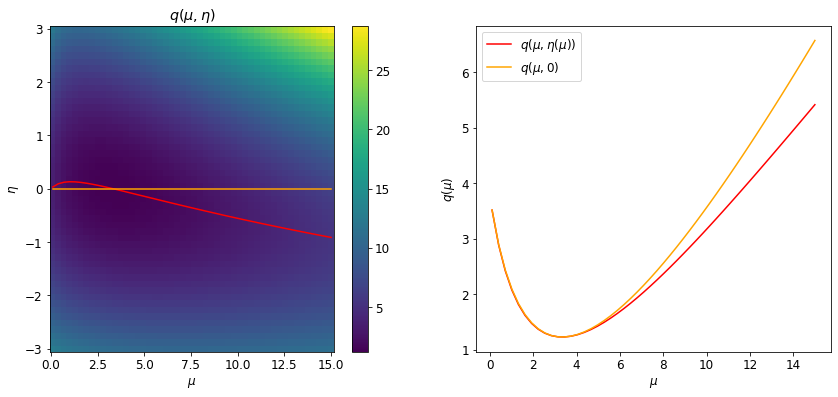

In [6]:
# plotting
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

# 1. plot q(mu,eta)
xaxis = numpy.linspace(0.1,15,50)
yaxis = numpy.linspace(-3,3,50)
z = [ [q(mu,eta) for mu in xaxis] for eta in yaxis ]
X,Y = numpy.meshgrid(xaxis,yaxis)
c = ax1.pcolor(X,Y,z)
fig.colorbar(c,ax=ax1)
ax1.set_xlabel("$\\mu$")
ax1.set_ylabel("$\eta$")
ax1.set_title("$q(\\mu,\eta)$")

# 2. plot the profiled value of eta as a function of mu
eta_mu = [ profiled_eta(mu) for mu in xaxis ]
ax1.plot(xaxis,eta_mu,color='red')
ax1.plot(xaxis,[0 for x in xaxis],color='orange')

# 2. plot the profile and conditional likelihood
q_mu   = [ q(mu,eta) for mu,eta in zip(xaxis,eta_mu)]
q_mu_0 = [ q(mu,0) for mu in xaxis]
ax2.plot(xaxis,q_mu,color='red',label="$q(\\mu,\eta(\\mu))$")
ax2.plot(xaxis,q_mu_0,color='orange',label="$q(\\mu,0)$")
ax2.set_xlabel("$\\mu$")
ax2.set_ylabel("$q(\\mu)$")
ax2.legend()

plt.savefig("prof_lh_ex.pdf")
plt.show()

## Marginalisation

In Bayesian statistics, the way to eliminate nuisance parameters is through *integrating* over the joint posterior distribution with respect to the nuisance parameters. This is known as *marginalisation*.  

For a single parameter of interest ($\mu$) and a single nuisance parameter ($\eta$), we have for our counting experiment, 

$$
p(\mu,\eta|n) = \frac{p(n|\mu,\eta)p(\mu,\eta)}{p(n)} =  \frac{p(n|\mu,\eta)p(\mu)p(\eta)}{p(n)}
$$

and therefore,  

$$
p(\mu|n) = \int \frac{p(n|\mu,\eta)p(\mu)p(\eta)}{p(n)}  d\eta
$$

where we have assimed that for our counting experiment, the prior on $\eta$ is is independent of $\mu$. We will assume a  *flat* prior for the parameter of interest too, and the prior on $\eta$ is a Normal distribution so that;

$$
p(\mu,\eta) = p(\mu)\cdot p(\eta) = \frac{1}{25}\cdot \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}\eta^{2}}, 
$$
if $\mu\in (0,25)$  and 0 otherwise. 

A usual, $p(n)=\int p(\mu|n)d\mu = \int\int p(\mu,\eta|n)d\mu d\eta$.

We introduce back the factorial term in the likelihood so that 

$$
p(n|\mu,\eta)  = \frac{L(\mu,\eta)}{n!}
$$

We can define the different terms as functions,

In [7]:
# Likelihood --> P(n|mu,eta)
def Likelihood(n,mu,eta):
  l = lamb(mu,eta)
  return (l**n)*numpy.exp(-l)/numpy.math.factorial(int(n))

# prior on eta P(eta)
def prior_eta(eta): 
  c = 1./((2*numpy.pi)**0.5)
  return c*numpy.exp(-0.5*eta*eta)

# prior on mu P(mu)
def prior_mu(mu):
  return 1./25 if (mu < 25 and mu > 0) else 0 

# and define the product of them (the numerator in Bayes rule)
def product(eta,mu,n):
  return Likelihood(n,mu,eta)*prior_mu(mu)*prior_eta(eta)

# and also define the product of them but fix eta=0
def product_eta_0(mu,n):
  return Likelihood(n,mu,0)*prior_mu(mu)*prior_eta(0)

We will use the `integrate.quad` method from `scipy` to do the intergration for us numerically, one for the integral over $\eta$ and one for the integral over $\eta$ and $\mu$. 

In [8]:
import scipy.integrate as integrate

# integrate over eta
def integral(mu,n):
  return integrate.quad(product,-6,6,args=(mu,n),epsabs=1.49e-03)[0]

# and then integrate over mu
def norm(n):
  return integrate.dblquad(product,0.01,25,lambda x:-6,lambda x:6,args=[n],epsabs=1.49e-03)[0]

# integrate over mu for fixed eta
def integral_eta_0(n):
  return integrate.quad(product_eta_0,0,25,args=(n),epsabs=1.49e-03)[0]


Lets see what this looks like for our simple counting experiment 

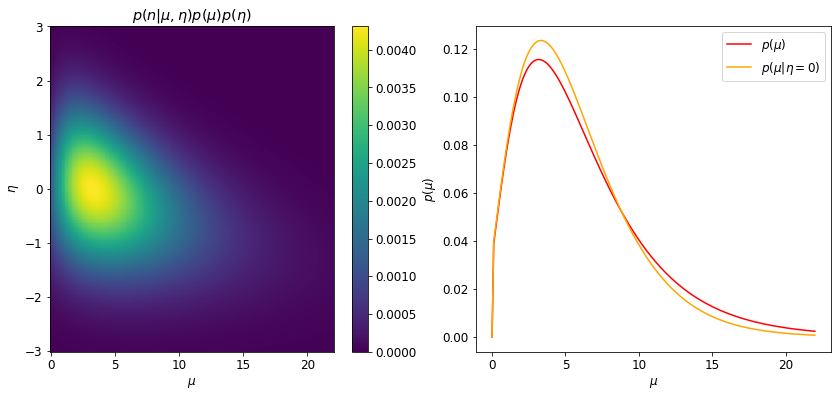

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

# plot the product of the likelihood and priors
xaxis = numpy.linspace(0.,22,200)
yaxis = numpy.linspace(-3,3,200)
z = [ [product(eta,mu,n) for mu in xaxis] for eta in yaxis ]
X,Y = numpy.meshgrid(xaxis,yaxis) 
c = ax1.pcolor(X,Y,z)
fig.colorbar(c,ax=ax1)
ax1.set_xlabel("$\\mu$")
ax1.set_ylabel("$\eta$")
ax1.set_title("$p(n|\\mu,\eta)p(\\mu)p(\eta)$")

normalise = norm(n)
# plot the posterior
p_mu = [ integral(mu,n)/normalise for mu in xaxis ]

normalise_eta_0 = integral_eta_0(n)
p_mu_eta_0 = [ product_eta_0(mu,n)/normalise_eta_0 for mu in xaxis ]

ax2.plot(xaxis,p_mu,color='red',label='$p(\\mu)$')
ax2.plot(xaxis,p_mu_eta_0,color='orange',label="$p(\\mu|\eta=0)$")
ax2.set_xlabel("$\\mu$")
ax2.set_ylabel("$p(\\mu$)")
ax2.legend()

plt.savefig("marginalised_lh_ex.pdf")
plt.show()

Remember that we can also use the MarkovChainMC approach to do the intergration...

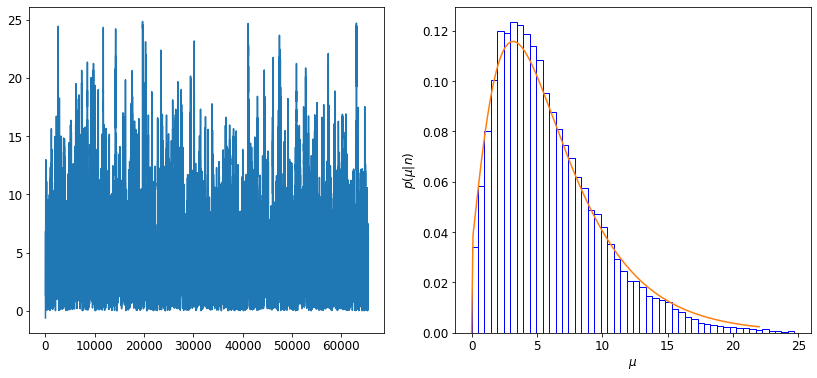

<Figure size 432x288 with 0 Axes>

In [10]:
def proposal(mu,eta):
    return numpy.random.normal(mu,1),numpy.random.normal(eta,1)

# function to accept new proposal or reject it 
def accept_or_reject(mu_new,eta_new,mu,eta):  
    # check for 0 
    if product(eta,mu,n) > 0: 
      r = product(eta_new,mu_new,n)/product(eta,mu,n)
    else:
      r = 2.
    if r > 1: 
        return mu_new,eta_new,True 
    else:
        alpha = min([r,1])
        rnd = numpy.random.uniform(0,1)
        if rnd < alpha : 
            return mu_new,eta_new,True
        else: return mu,eta,False

init = proposal(1,0)
accepted_mc = []

number_steps = 100000
for i in range(number_steps) :
    
    mu_new,eta_new = proposal(init[0],init[1])
    mu_new,eta_new,accept = accept_or_reject(mu_new,eta_new,init[0],init[1])
    init = [mu_new,eta_new]
    if accept: accepted_mc.append(mu_new)

# plot the accepted points, overlay the numerical result - use a burn-in of 20,000 points
accepted_mc_MH = accepted_mc[20000:-1]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
ax1.plot(range(len(accepted_mc)),accepted_mc)
ax2.hist(accepted_mc_MH,density=True,fill=False,edgecolor='blue',bins=50)

ax2.plot(xaxis, p_mu)
ax2.set_xlabel("$\mu$")
ax2.set_ylabel("$p(\mu|n)$")
plt.show()
plt.savefig("counting_experiment_bayes_MCMC.pdf")

We'll be using this simple counting experiment again so i'll save a bunch of the functions we used in `counting_model_functions.py`. We'll see later that we will need to throw pseudo-data - for us thats the value of $n$ and $\eta^{\prime}$ which here are 2 and 0 respectively. This means our functions need to take these as arguments but otherwise, are essentially the same. 